# Crime Type Classification using LAPD Data (2020–Present)
 
### **Dataset Description**
This project uses the publicly available **Crime Data from 2020 to Present** published by the **Los Angeles Police Department (LAPD)**.  
Each row in the dataset represents a single reported crime incident and includes:

- When the crime occurred (date and time)
- Location (police area, reporting district, latitude/longitude)
- Victim demographics (age, sex, descent)
- Crime type classification
- Context information (e.g., where it happened, whether a weapon was used)

**Goal:**  
We aim to **predict the type of crime** (`Crm Cd Desc`) using relevant victim, location, and context features.

**Dataset Source:**  
Los Angeles Open Data Portal – *Crime Data from 2020 to Present*
https://catalog.data.gov/dataset/crime-data-from-2020-to-present


## Crime Category Grouping for Classification

The original LAPD dataset contains **over 140 unique crime labels**, many of which differ only by severity level, value, victim type, or whether the crime was attempted or completed.  
For example:

- **Bike – Stolen** and **Bike – Attempted Stolen**
- **Petty Theft**, **Grand Theft**, and **Employee Theft**
- **Burglary** vs. **Burglary from Vehicle**
- **Battery**, **Battery on a Police Officer**, and **Simple Assault**

Although legally distinct, these variations represent **the same type of criminal action**, and predicting them as separate labels would produce excessive class imbalance, unnecessary classifier complexity, and reduced predictive insight.

To support meaningful machine learning classification, we grouped crimes into broader **action-based categories**, where labels represent **what type of crime occurs**, not small legal variations of it. The grouping follows four principles:

- Crimes are merged when they differ only by value, victim category, or attempt/completion.
- Theft-related crimes (shoplifting, bunco scams, employee theft, etc.) are treated as **Theft**.
- Vehicle theft remains a separate category from general theft due to unique patterns and predictive features.
- All sexual crimes (rape, sexual battery, sodomy, child pornography, lewd conduct, etc.) are grouped into **Sex Offense**

We do not aim to predict specific penal code labels. Instead, we predict **the type of crime being reported**, based on victim demographics, context, and location features.


### Attributes Selected

To predict the category of crime, we selected features that reflect demographic, spatial, and situational characteristics that strongly correlate with criminal patterns. The following attributes were retained:

| Attribute | Rationale |
|----------|-----------|
| **Vict Sex** | Certain crimes disproportionately impact a specific gender (e.g., sexual assault, intimate partner violence). |
| **Vict Descent** | Some crime types show demographic targeting patterns due to social, geographic, and economic factors. |
| **Vict Age Group** | Age correlates with vulnerability or participation in different crimes (e.g., fraud against elderly, crimes against children). |
| **Premis Desc** | One of the most predictive features; different crimes occur in distinct locations (street, home, store, vehicle, etc.). |
| **AREA NAME** | Geographic regions have distinct crime clusters influenced by local socioeconomic conditions. |
| **Time Period** | Crimes occur at different times of day (e.g., burglaries in mid-day, robberies in evening, vandalism at night). |

These attributes are interpretable, have low missing values, and reflect real-world predictors used in criminology. They provide strong predictive value without leaking the true label as no attribute directly reveals the crime category.


In [25]:
# ================================================================
# LAPD Crime Data — Loading + Preprocessing + Label Grouping
# ================================================================

# ------------ Imports & Project Path Setup ------------
import sys
import os
import pandas as pd

# Add project root to Python path so `mysklearn` package can be imported
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import preprocessing helpers 
from mysklearn.mypreprocessing import load_raw_crime_data, extract_features, build_X_y

# Dataset Path Auto-Detection 
possible_paths = [
    "data/Crime_Data_from_2020_to_Present.csv",        # if notebook open in project root
    "../data/Crime_Data_from_2020_to_Present.csv"      # if notebook open from /notebooks
]

csv_path = next((p for p in possible_paths if os.path.exists(p)), None)

if csv_path is None:
    raise FileNotFoundError("Could not locate dataset. Ensure it is in the /data directory.")

#  Load Raw Dataset 
raw_df = load_raw_crime_data(csv_path)
print(f" Loaded dataset from: {csv_path}")
print("Loaded raw dataset shape:", raw_df.shape)

#  Feature Extraction + Crime Category Mapping 
clean_df = extract_features(raw_df)
print("Processed dataset shape:", clean_df.shape)

#  Show Columns After Cleaning 
print("\nColumns after preprocessing:\n")
print(clean_df.columns.to_list())

#  Show Category Distribution 
print("\nCrime Category Counts:\n")
print(clean_df["Crime Category"].value_counts())


 Loaded dataset from: ../data/Crime_Data_from_2020_to_Present.csv
Loaded raw dataset shape: (1004991, 28)
Processed dataset shape: (855119, 7)

Columns after preprocessing:

['Vict Sex', 'Vict Descent', 'Premis Desc', 'AREA NAME', 'Vict Age Group', 'Time Period', 'Crime Category']

Crime Category Counts:

Crime Category
Assault               191632
Theft                 146758
Burglary              126046
Vehicle Theft         122329
Property Damage        86480
Fraud                  67702
Robbery                43504
Threats/Harassment     30660
Weapons                19413
Sex Offense            14186
Arson                   2568
Homicide                1577
Kidnapping              1385
Trafficking              879
Name: count, dtype: int64


### Frequency of Crime Categories

**Figure 1.** The plot below shows the frequency of each major crime category after grouping over 140 legal offense labels into broader categories. Property-related crimes such as **Theft**, **Burglary**, and **Vehicle Theft** are the most common, followed by **Assault**. Less frequent crimes like **Homicide**, **Trafficking**, and **Kidnapping** still remain in the dataset to avoid bias toward high-frequency labels.

This distribution reveals that the dataset is **imbalanced**, meaning that classifier performance must be evaluated beyond simple accuracy. Since rare crimes still represent significant public safety concerns, they are kept in the classification task rather than being removed.


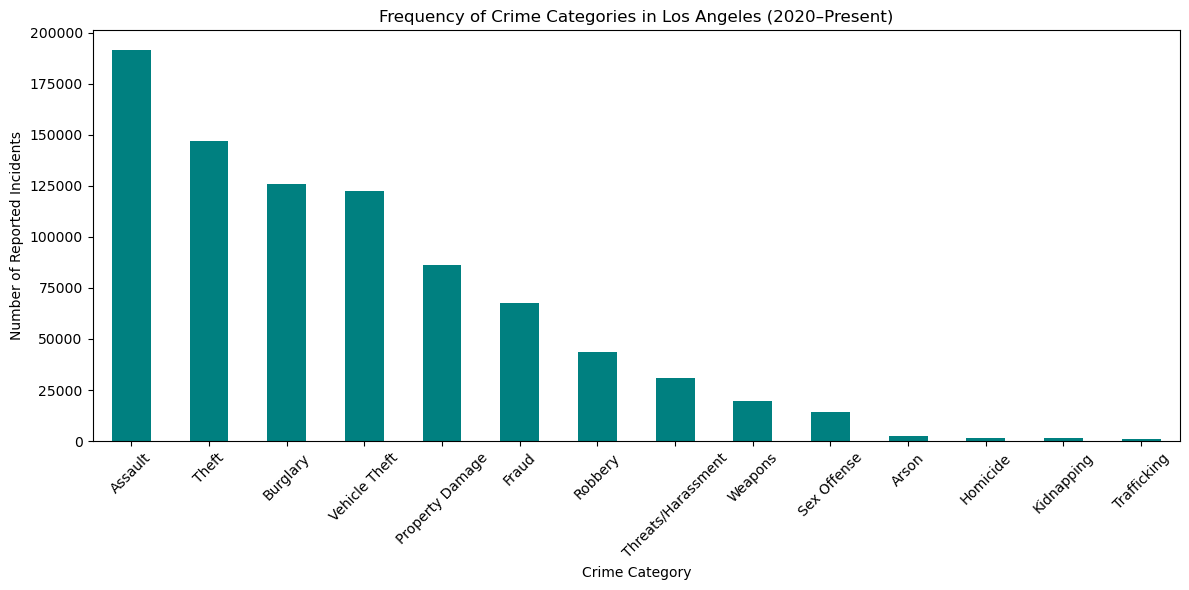

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
clean_df["Crime Category"].value_counts().plot(kind="bar", color="teal")
plt.title("Frequency of Crime Categories in Los Angeles (2020–Present)")
plt.xlabel("Crime Category")
plt.ylabel("Number of Reported Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Crime Category by Time of Day

**Figure 2.** This visualization compares crime type with the time of day at which the incident occurred. **Robbery** and **Vehicle Theft** show clear spikes during the **evening and night**, while crimes like **Burglary** and **Fraud** occur more frequently during **daytime business hours**.

People are more vulnerable to robbery on streets at night, while fraud and burglary often happen during the day when financial transactions and home activity are more common. This supports using **Time Period** as a meaningful predictor in our classifier models.


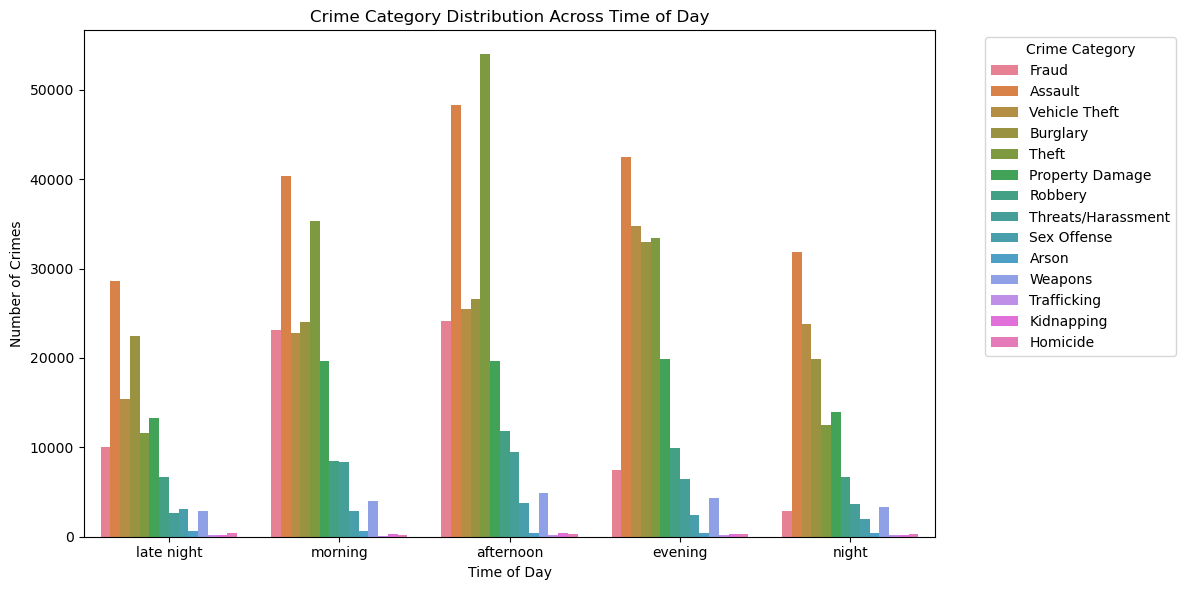

In [29]:
plt.figure(figsize=(12, 6))
sns.countplot(data=clean_df, x="Time Period", hue="Crime Category")
plt.title("Crime Category Distribution Across Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=0)
plt.legend(title="Crime Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Crime Categories by Location Type

**Figure 3.** Crime type varies significantly based on where the incident takes place. For example, **Burglary** is concentrated at **residences**, **Vehicle Theft** occurs in **streets and parking areas**, and **Robbery** happens in public places such as **sidewalks, stores, and transit locations**.

Location acts as a natural indicator of how a crime occurs, meaning the attribute **Premis Desc** provides strong predictive value. This reinforces that spatial context is one of the most informative features when classifying crime into categories.


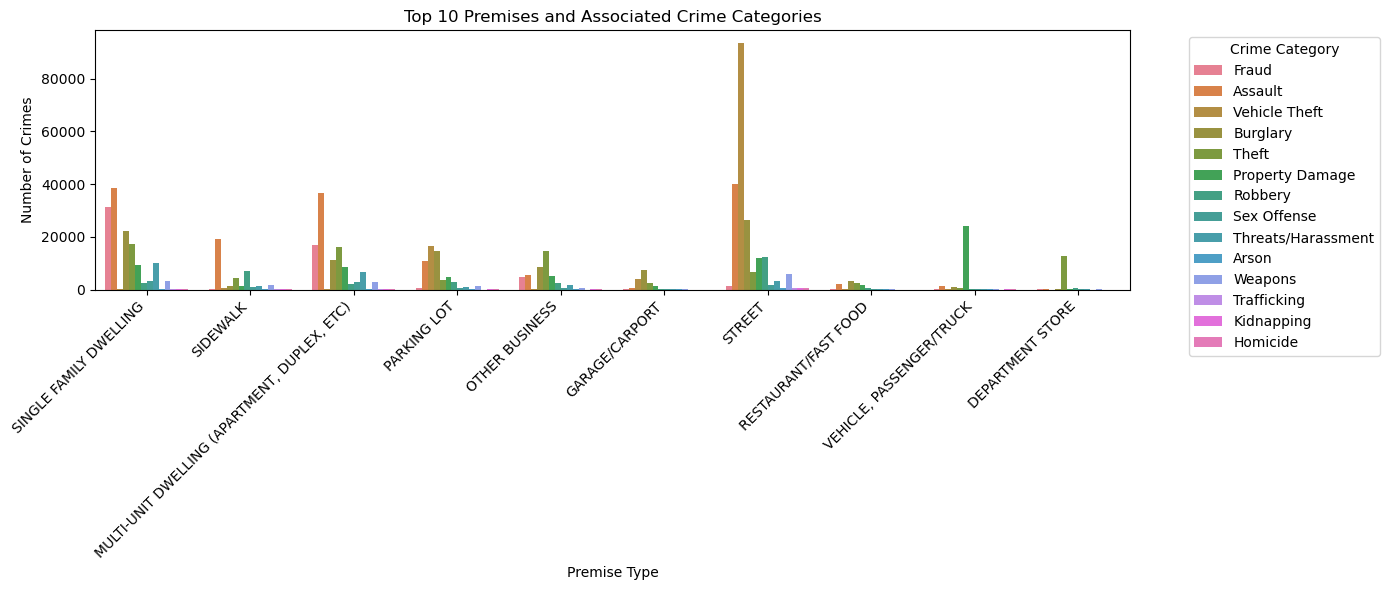

In [30]:
top_premises = clean_df["Premis Desc"].value_counts().nlargest(10).index
subset = clean_df[clean_df["Premis Desc"].isin(top_premises)]

plt.figure(figsize=(14, 6))
sns.countplot(data=subset, x="Premis Desc", hue="Crime Category")
plt.title("Top 10 Premises and Associated Crime Categories")
plt.xlabel("Premise Type")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Crime Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
